In [12]:
import sys
sys.path.append('../voicemap/')
sys.path.append('../')
from IPython.display import SVG, Audio, display
from librispeech import LibriSpeechDataset
from utils import whiten, contrastive_loss, preprocess_instances, BatchPreProcessor
from config import LIBRISPEECH_SAMPLING_RATE
from voicemap.models import get_baseline_convolutional_encoder, build_siamese_net
from keras.optimizers import Adam
import numpy as np
import pandas as pd
from keras.models import load_model
import keras.backend as K
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## Initialising all Parameters
n_seconds = 4
downsampling = 4
batchsize = 64
filters = 128
embedding_dimension = 64
dropout = 0.0
input_length = int(LIBRISPEECH_SAMPLING_RATE * n_seconds / downsampling)
# model_path = '../models_new/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
# model_path = '../models_e50_cluster/n_seconds/siamese__nseconds_1.0__filters_128__embed_64__drop_0.0__r_0.hdf5'
model_path ='../models_retry/n_seconds/siamese__nseconds_4__filters_128__embed_64__drop_0.0__r_0.hdf5'
# model_path ='../models_360/n_seconds/siamese__nseconds_5__filters_128__embed_64__drop_0.0__r_0.hdf5'

In [14]:
#Load model
encoder = get_baseline_convolutional_encoder(filters, embedding_dimension, dropout=dropout)
siamese = build_siamese_net(encoder, (input_length, 1), distance_metric='uniform_euclidean')
opt = Adam(clipnorm=1.)
siamese.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#siamese = load_model(model_path)
siamese.load_weights(model_path)

## Encoder


In [15]:
from keras.models import Model
from keras.layers import Input
from keras.utils.vis_utils import model_to_dot
## Load Encoder
inputs = Input(shape=(input_length,1))
encoded = siamese.layers[2](inputs)
encoder = Model(inputs=inputs, outputs=encoded)
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

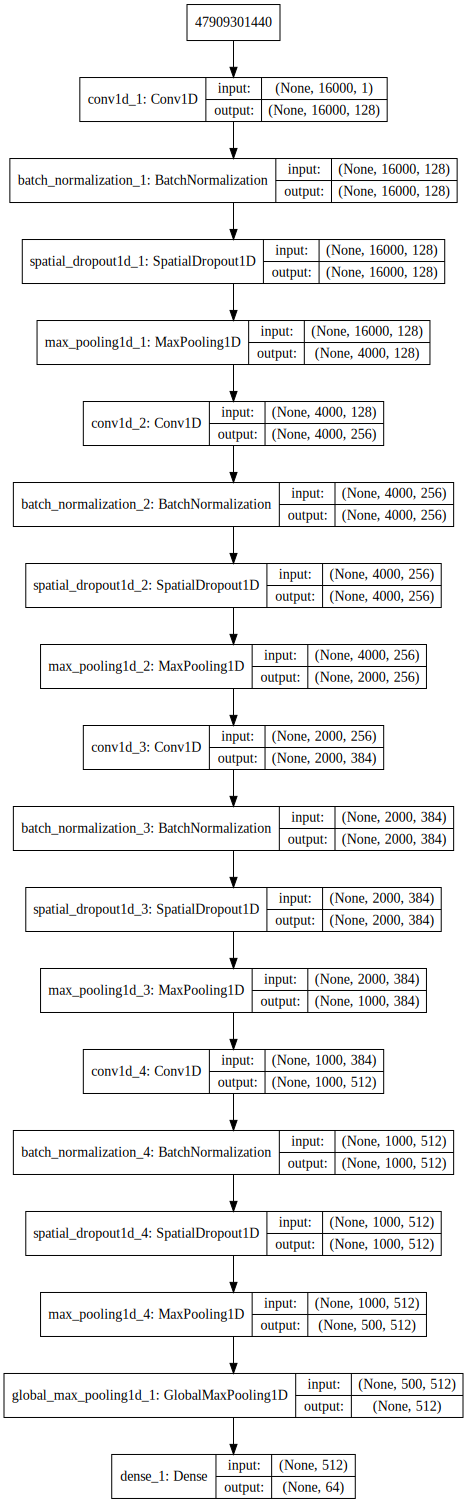

In [5]:
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

In [16]:
## Training
training_set = ['train-clean-100']
train = LibriSpeechDataset(training_set, n_seconds, stochastic=True, pad=True)#, cache=False)
## Validation
validation_set = ['dev-clean']
valid = LibriSpeechDataset(validation_set, n_seconds, stochastic=True, pad=True)#,cache=False)

Initialising LibriSpeechDataset with minimum length = 4s and subsets = ['train-clean-100']
Finished indexing data. 28442 usable files found.
Initialising LibriSpeechDataset with minimum length = 4s and subsets = ['dev-clean']
Finished indexing data. 2703 usable files found.


In [17]:
batch_preprocessor = BatchPreProcessor("classifier", preprocess_instances(downsampling))
preprocessor = batch_preprocessor

In [18]:
from sklearn.model_selection import train_test_split
## Split the train filenames to train, val_speakers

speaker_list=train.df["speaker_id"]
train_arr_filenames=train.df['filepath']
print(train_arr_filenames.shape)

indices = np.arange(len(train_arr_filenames))
ind_train, ind_test = train_test_split(indices, test_size=0.33, random_state=42)

X_train_files = train_arr_filenames[ind_train]
X_test_files = train_arr_filenames[ind_test]
y_train = speaker_list[ind_train]
y_test = speaker_list[ind_test]

(28442,)


# Classifier of Embeddings

In [19]:
def read_data(input_data, train=train):
    X_array =[]
    #instance, sr = sf.read(input_data[i])
    for i in input_data.index.values:
        instance, sp = train[i]
        X_array.append(instance)
    X_array = np.array(X_array)
    return X_array

In [20]:
def extract_embedding(X_array, encoder):
    query_instance_ = preprocessor.instance_preprocessor(X_array[:,:,np.newaxis])
    print(len(query_instance_))
    emb = encoder.predict(query_instance_)
    #emb = encoder.predict_on_batch(query_instance_)
    #emb = encoder(query_instance_)
    return emb

In [21]:
train.read_audio_dataset()
train.pre_read = True

Loaded audio file into DataFrame


In [22]:
## Changed from train to valid
X_read = read_data(X_train_files, train)
print(X_read.shape)
val_read = read_data(X_test_files,train)
print(val_read.shape)

(19056, 64000)
(9386, 64000)


In [23]:
emb = extract_embedding(X_read, encoder)

19056


In [ ]:
val_emb = extract_embedding(val_read, encoder)

9386


In [18]:
np.save('./saved_data/emb_4sec_sampling.npy',emb)
np.save('./saved_data/val_emb_4sec_sampling.npy',val_emb)

#emb=np.load('./saved_data/emb_3sec_r.npy')
#val_emb = np.load('./saved_data/val_emb_3sec_r.npy')

In [15]:
from sklearn import svm
## Train Classifier
X_tr = emb
y_tr = y_train
clf = svm.SVC(gamma = 'scale', probability=True)
clf.fit(X_tr, y_tr) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
y_pred = clf.predict(val_emb)
#probs = clf.predict_proba(val_emb)
y_val = y_test
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.663754528020456


In [15]:
# import pickle
# with open('clf_5_r.pkl', 'rb') as f:
#     clf = pickle.load(f)
# val_emb = np.load('saved_data/val_emb_5sec_r.npy')
# print("loaded")
y_pred = clf.predict(val_emb)
probs = clf.predict_proba(val_emb)
y_val = y_test
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

loaded
0.7642233113147241


In [17]:
## Saving classifier
import pickle
with open('clf_4_sampling.pkl', 'wb') as f:
    pickle.dump(clf, f)
## Loading pre-saved classifier 
# import pickle
# with open('clf_2.pkl', 'rb') as f:
#     clf = pickle.load(f)

In [23]:
import soundfile as sf
def evaluate(input_data, encoder=encoder, classifier=clf, train=train, X_train_files=X_train_files):
    if isinstance(input_data,pd.core.series.Series):
        X_read = read_data(input_data, train)
    elif isinstance(input_data,str):
        if input_data in train.df['filepath'].values:
            X_read, _ = train[train.df[train.df['filepath'].values==input_data].index.values[0]]
            X_read = X_read.reshape(1,-1)
    #print(X_read.shape)
    X_emb = extract_embedding(X_read, encoder)
    y_pred = clf.predict(X_emb)
    probs = clf.predict_proba(X_emb)
    return y_pred, probs

### Overlapped conversation

In [210]:
overlap_files = ['/Users/sanmathikamath/projects/datasets/overlap-male27-male26.flac',
                 '/Users/sanmathikamath/projects/datasets/overlap-male27-female103.flac',
                '/Users/sanmathikamath/projects/datasets/overlap-male7264-female103.flac', 
                 '/Users/sanmathikamath/projects/datasets/overlap-female7302-female103.flac']

# read_data(overlap_files[0])
# train_arr_filenames[0:1].index, overlap_files.index, 
# train.df['filepath'].isin([overlap_files[0]]).any()
# instance, sr = sf.read(overlap_files[0])
# instance.shape

In [212]:
import soundfile as sf

sr =16000
block_size = sr*n_seconds
# blocks_ = np.zeros(block_size)
instances = []
for f in [overlap_files[0]]:
    blocks = sf.blocks(f, blocksize=block_size, overlap = block_size - sr)
    for j in blocks :
        instances.append(j)
    instances = instances[:-1]

instances=np.array(instances)
emb_overlap = extract_embedding(np.array(instances), encoder)
prob_overlap = clf.predict_proba(emb_overlap)
preds = clf.predict(emb_overlap)
print(preds, threshold)
preds[np.max(prob_overlap, axis =1)<threshold] = 0
preds

NameError: name 'threshold' is not defined

Predicted class [84]
Actual classes [212] [10]


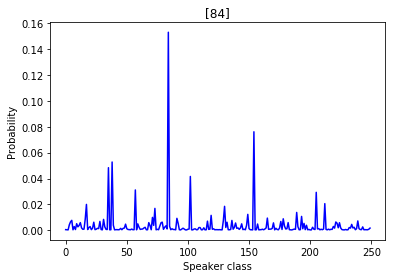

In [320]:
import matplotlib.pyplot as plt
i= 1
fig, ax = plt.subplots(1,1)
ax.plot(prob_overlap[i],'b')
ax.set_ylabel('Probability')
ax.set_xlabel('Speaker class')
ax.set_title(np.where(np.unique(y_tr) == preds[i])[0])

print('Predicted class', np.where(np.unique(y_tr) == preds[i])[0])
print('Actual classes', np.where(np.unique(y_tr) == 7302)[0], np.where(np.unique(y_tr) == 103)[0])

## Plotting prob distribution

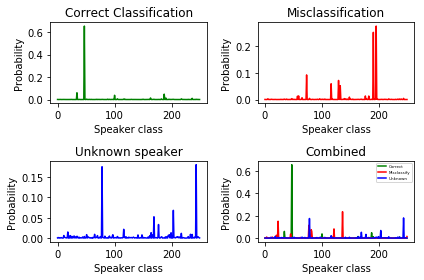

In [132]:
## Plotting prob distribution

correct_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] == y_val]
incorrect_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] != y_val]

##Unknown
unknown, sr = valid[100]
query_instance_ = preprocessor.instance_preprocessor(unknown.reshape(1,-1,1))
emb_unknown = encoder.predict(query_instance_)
probs_unknown = clf.predict_proba(emb_unknown)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2)
ax[0,0].plot(correct_probs[0],'g')
ax[0,0].set_ylabel('Probability')
ax[0,0].set_xlabel('Speaker class')
ax[0,0].set_title('Correct Classification')

ax[0,1].plot(incorrect_probs[0], 'r')
ax[0,1].set_ylabel('Probability')
ax[0,1].set_xlabel('Speaker class')
ax[0,1].set_title('Misclassification')

ax[1,0].plot(probs_unknown[0],'b')
ax[1,0].set_ylabel('Probability')
ax[1,0].set_xlabel('Speaker class')
ax[1,0].set_title('Unknown speaker')

ax[1,1].plot(correct_probs[0],'g')
ax[1,1].plot(incorrect_probs[100], 'r')
ax[1,1].plot(probs_unknown[0],'b')
ax[1,1].set_ylabel('Probability')
ax[1,1].set_xlabel('Speaker class')
ax[1,1].legend(['Correct', 'Misclassify', 'Unknown'],fontsize =4, loc=1)
ax[1,1].set_title('Combined')
plt.tight_layout()
plt.show()
#fig.savefig('plots_3sec.png', dpi=250)

In [26]:
#Compute kurosis
from scipy.stats import kurtosis
kurtosis(probs_unknown, axis=1)
kurtosis(probs, axis = 1)
correct_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] == y_val]
incorrect_probs = probs[np.unique(y_val)[np.argmax(probs, axis=1)] != y_val]
print("Kurtosis for correct predictions: Mean:", np.mean(kurtosis(correct_probs, axis=1)), 
      "Std:", np.std(kurtosis(correct_probs, axis=1)),
      "\nKurtosis for incorrect predictions: Mean:",
      np.mean(kurtosis(incorrect_probs, axis =1)), "Std:",
      np.std(kurtosis(incorrect_probs, axis=1)),
      "\nKurtosis of one Unknown file:",
      kurtosis(probs_unknown, axis=1))
#probs_unknown


Kurtosis for correct predictions: Mean: 203.82340640261293 Std: 49.87805813441787 
Kurtosis for incorrect predictions: Mean: 123.20446374862435 Std: 53.5608958446859 
Kurtosis of one Unknown file: [162.16805625]


## Calculate threshold for unknown speakers

In [213]:
# Mean probability to calculate threshold
#probability distribution of training set
probs_tr = clf.predict_proba(emb)

correct_probs = probs_tr[np.unique(y_tr)[np.argmax(probs_tr, axis=1)] == y_tr]
incorrect_probs = probs_tr[np.unique(y_tr)[np.argmax(probs_tr, axis=1)] != y_tr]

print(np.mean(np.max(correct_probs, axis=1)), np.std(np.max(correct_probs, axis=1)))
print(np.mean(np.max(incorrect_probs, axis=1)), np.std(np.max(incorrect_probs, axis=1)))

# np.mean(np.max(probs_unknown, axis=1))

0.47172047944294215 0.1655851819945734
0.307858311227539 0.1206186303158979


In [277]:
# threshold = (np.mean(np.max(correct_probs, axis=1) + np.mean(np.max(incorrect_probs, axis=1))/2
# Average between the mean max probability in correct predictions and mean max probability in incorrect predictions 
# in train section

# Considering approx 
threshold = np.mean(np.max(probs_tr, axis =1)) - np.std(np.max(probs_tr, axis =1))
threshold

0.3421510335220802

In [278]:
y_val = y_test
y_pred = clf.predict(val_emb)
probs = clf.predict_proba(val_emb)
y_pred[np.max(probs, axis =1)< threshold] = 0
print(accuracy_score(y_val, y_pred))

0.7234178563818453


In [199]:
len(np.where(y_pred == 0)[0]), len(y_pred)
np.max(probs, axis =1)[np.where(y_pred == 0)[0]]

array([0.27359939, 0.29990715, 0.269823  , ..., 0.14265214, 0.28822283,
       0.26155386])

## Data distribution

In [119]:
y_unique, y_counts = np.unique(y_train, return_counts = True)
a, b = np.unique(y_test, return_counts = True)


(array([  19,   26,   27,   32,   39,   40,   78,   83,   87,   89,  103,
         118,  125,  150,  163,  196,  198,  200,  201,  211,  226,  229,
         233,  248,  250,  254,  289,  298,  302,  307,  311,  322,  328,
         332,  374,  403,  405,  412,  426,  441,  445,  446,  458,  460,
         481,  587,  625,  669,  696,  730,  831,  839,  887,  909,  911,
        1034, 1040, 1069, 1081, 1088, 1098, 1116, 1183, 1235, 1246, 1263,
        1334, 1355, 1363, 1447, 1455, 1502, 1553, 1578, 1594, 1624, 1723,
        1737, 1743, 1841, 1867, 1898, 1926, 1963, 1970, 1992, 2002, 2007,
        2092, 2136, 2159, 2182, 2196, 2289, 2384, 2391, 2416, 2436, 2514,
        2518, 2691, 2764, 2817, 2836, 2843, 2893, 2910, 2911, 2952, 2989,
        3112, 3168, 3214, 3235, 3240, 3242, 3259, 3374, 3436, 3440, 3486,
        3526, 3607, 3664, 3699, 3723, 3807, 3830, 3857, 3879, 3947, 3982,
        3983, 4014, 4018, 4051, 4088, 4137, 4160, 4195, 4214, 4267, 4297,
        4340, 4362, 4397, 4406, 4441, 

In [192]:
## Plot kutisis
plt.plot(kurtosis(correct_probs, axis =1), 'g')
plt.plot(kurtosis(incorrect_probs, axis=1), 'r')
plt.plot(kurtosis(probs_unknown, axis=1),'b')

NameError: name 'kurtosis' is not defined

def plot_confusion_matrix(cm,classes,
                          title=None,
                          cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(250,250))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
classes = np.arange(250)
plot_confusion_matrix(cm,classes,title='Confusion matrix')
#plt.show()

In [ ]:
#models_e50_cluster, Models_e50_full, #Models_new, n=1seconds, n=2seconds,
0.031216, 0.005327, 0.867, 0.25708, 0.1867

### Experiment with varying num-speakers

In [14]:
def num_speakers_train(X_train_files, y_train, two_spkr, emb=None):
    X_two_train =[]
    y_two_train =[]
    if emb is None:
        spkr1=X_train_files[y_train == two_spkr[0]]
        spkr1_emb = extract_embedding(spkr1, train)
    else:
        spkr1_emb = emb[y_train == two_spkr[0]]
    X_two_train = spkr1_emb
    y_spkr1 = np.stack([two_spkr[0]]*len(spkr1_emb))
    y_two_train = y_spkr1
    
    for i in range(1, len(two_spkr)):
        if emb is None:
            spkr1=X_train_files[y_train == two_spkr[i]]
            spkr1_emb = extract_embedding(spkr1, train)
        else:
            spkr1_emb = emb[y_train == two_spkr[i]]
        y_spkr1 = np.stack([two_spkr[i]]*len(spkr1_emb))
        X_two_train = np.vstack((X_two_train,spkr1_emb))
        y_two_train = np.hstack((y_two_train,y_spkr1))
    
    return (X_two_train, y_two_train)

In [15]:
def num_speakers_val(X_test_files, y_test, two_spkr, val_emb = None):
    X_two_val =[]
    y_two_val =[]
    if val_emb is None:
        spkr1=X_test_files[y_test == two_spkr[0]]
        spkr1_emb = extract_embedding(spkr1, train)
    else:
        spkr1_emb = val_emb[y_test == two_spkr[0]]
    X_two_val = spkr1_emb
    y_spkr1 = np.stack([two_spkr[0]]*len(spkr1_emb))
    y_two_val = y_spkr1

    for i in range(1, len(two_spkr)):
        if val_emb is None:
            spkr1=X_test_files[y_test == two_spkr[i]]
            spkr1_emb = extract_embedding(spkr1, train)
        else:
            spkr1_emb = val_emb[y_test == two_spkr[i]]
        y_spkr1 = np.stack([two_spkr[i]]*len(spkr1_emb))
        X_two_val = np.vstack((X_two_val,spkr1_emb))
        y_two_val = np.hstack((y_two_val,y_spkr1))
    
    return (X_two_val, y_two_val)

In [16]:
from sklearn.metrics import accuracy_score
speaker_range = [2, 5, 10, 50, 100]
##Try multiple times and average out
num_reps = 100

total_acc_list =[]
for num_speakers in speaker_range:
    acc=[]
    for i in range(num_reps):
        two_spkr = np.random.choice(np.unique(y_train),num_speakers, replace = False)
        #print("Trial:", i)
        #, "Speakers:", two_spkr)
        X_two_train, y_two_train = num_speakers_train(X_train_files, y_train, two_spkr, emb)
        clf2 = svm.SVC(gamma = 'scale', probability=True)
        clf2.fit(X_two_train, y_two_train) 

        X_two_val, y_two_val = num_speakers_val(X_test_files, y_test, two_spkr, val_emb)
        y_pred = clf2.predict(X_two_val)
        y_val = y_two_val
        acc.append(accuracy_score(y_val, y_pred))
        #print("Accuracy:",acc[i])
    print("Num Speakers:", num_speakers, "Accuracy: mean", np.mean(np.array(acc)),"std:", np.std(np.array(acc)))
    total_acc_list.append(acc)


Num Speakers: 2 Accuracy: mean 1.0 std: 0.0
Num Speakers: 5 Accuracy: mean 0.989897298461903 std: 0.019397200239654966
Num Speakers: 10 Accuracy: mean 0.9746918594247185 std: 0.02079454836270818
Num Speakers: 50 Accuracy: mean 0.8937067395906232 std: 0.016541131860554028


KeyboardInterrupt: 

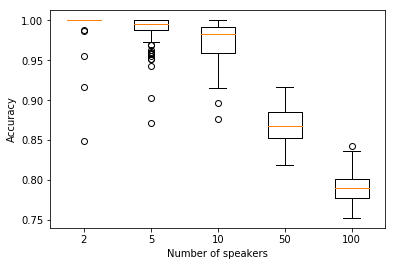

In [66]:
import matplotlib.pyplot as plt
total_acc_list = np.array(total_acc_list)
np.save('./saved_data/acc_4sec_360.npy',total_acc_list)
plt.boxplot(np.transpose(total_acc_list), labels= speaker_range)
# plt.ylim((0,1))
plt.xlabel('Number of speakers')
plt.ylabel('Accuracy')
plt.show()

In [90]:
## for unknown speakers
from sklearn.metrics import accuracy_score
speaker_range = [2, 5, 10, 50, 100]
##Try multiple times and average out
num_reps = 100

total_acc_list = []
two_acc_list = []
other_acc_list = []
for num_speakers in speaker_range:
    acc=[]
    acc_two =[]
    acc_other = []
    print("Num Speakers:", num_speakers)
    for i in range(num_reps):
        two_spkr = np.random.choice(np.unique(y_train),num_speakers, replace = False)

        other_spkr_set = np.delete(np.unique(y_train),np.where(np.in1d(np.unique(y_train), two_spkr))[0])
        two_other_spkr = np.random.choice(other_spkr_set,num_speakers, replace = False)

        ##Training
        X_two_train, y_two_train = num_speakers_train(X_train_files, y_train, two_spkr, emb)
        clf2 = svm.SVC(gamma = 'scale', probability=True)
        clf2.fit(X_two_train, y_two_train) 
        probs_train = clf2.predict_proba(X_two_train)
        thr = np.mean(np.max(probs_train, axis =1)) - np.std(np.max(probs_train, axis =1))

        ## Validation
        #Other spkrs [num-spkrs]
        X_two_other, y_two_other = num_speakers_val(X_test_files, y_test, two_other_spkr, val_emb)
        y_pred_other = clf2.predict(X_two_other)
        probs_other = clf2.predict_proba(X_two_other)
        y_pred_other[np.max(probs_other, axis =1)< thr] = 0
        y_val_other = np.zeros(len(y_two_other)) #Set unknown to zero

        #Selected spkrs [num-spkrs]
        X_two_val, y_two_val = num_speakers_val(X_test_files, y_test, two_spkr, val_emb)
        y_pred_two = clf2.predict(X_two_val)
        probs_two = clf2.predict_proba(X_two_val)
        y_pred_two[np.max(probs_two, axis =1)< thr] = 0
        y_val_two = y_two_val 

        #Total 2*[num-spkrs]
        y_val = np.hstack((y_val_two, y_val_other))
        y_pred = np.hstack((y_pred_two, y_pred_other))


        acc_two.append(accuracy_score(y_val_two, y_pred_two))
        acc_other.append(accuracy_score(y_val_other, y_pred_other))
        acc.append(accuracy_score(y_val, y_pred))

    print("Threshold:", thr)
    print("Overall accuracy:", np.mean(np.array(acc)), np.std(np.array(acc)))
    print("Accuracy of known speakers", np.mean(np.array(acc_two)), np.std(np.array(acc_two)))
    print("Accuracy of unknown speakers", np.mean(np.array(acc_other)), np.std(np.array(acc_other)))
    
    total_acc_list.append(acc)
    two_acc_list.append(acc_two)
    other_acc_list.append(acc_other)
    

Num Speakers: 2
Threshold: 0.9850471686355589
Overall accuracy: 0.8790598286548759 0.10396550560011565
Accuracy of known speakers 0.8583919286542939 0.05680956799208291
Accuracy of unknown speakers 0.896399393140595 0.21783837223227986
Num Speakers: 5
Threshold: 0.9456214102171024
Overall accuracy: 0.9035397727124037 0.048907490068907405
Accuracy of known speakers 0.8952278094073509 0.03703595765348663
Accuracy of unknown speakers 0.9118205542862478 0.09410109031214402
Num Speakers: 10
Threshold: 0.8711437366385216
Overall accuracy: 0.8889303100296158 0.03617434641830528
Accuracy of known speakers 0.8820524795434741 0.01874204857750694
Accuracy of unknown speakers 0.8958148035932193 0.07228311353289474
Num Speakers: 50
Threshold: 0.6214881950817963
Overall accuracy: 0.8281844187569457 0.019782275689248365
Accuracy of known speakers 0.8115388520945391 0.011273236385725948
Accuracy of unknown speakers 0.8449154836839341 0.03594331740048651
Num Speakers: 100
Threshold: 0.5378855047944735


In [91]:
total_acc_list = np.array(total_acc_list)
two_acc_list = np.array(two_acc_list)
other_acc_list = np.array(other_acc_list)

np.save('./saved_data/acc_3sec_thr1_both.npz',total_acc_list)
np.save('./saved_data/acc_3sec_thr1_two.npz',two_acc_list)
np.save('./saved_data/acc_3sec_thr1_other.npz',other_acc_list)


In [71]:
len(total_acc_list), len(two_acc_list)

(5, 5)

0.0


/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


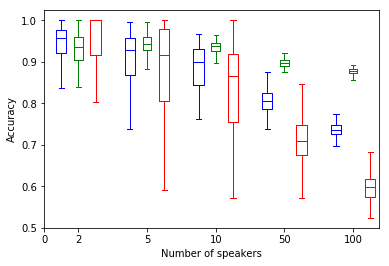

In [88]:
box = plt.boxplot(np.transpose(total_acc_list), \
                  positions = (1,5,9,13, 17), \
                  widths =0.6,
                  #labels= speaker_range, 
                  showfliers=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box[element], color='blue')

box2 = plt.boxplot(np.transpose(two_acc_list), \
                   positions =(2, 6,10,14, 18),\
                   #labels= speaker_range, 
                   showfliers=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box2[element], color='green')
        
box2 = plt.boxplot(np.transpose(other_acc_list), \
                   positions =(3,7,11,15, 19),\
                   widths = 0.6,
                   #labels= speaker_range, 
                   showfliers=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box2[element], color='red')
ax = plt.axes()
ax.set_xticklabels([0,2,5,10,50,100])
ax.set_xticks([0,2, 6,10,14, 18])
# plt.ylim((0,1))

plt.xlabel('Number of speakers')
plt.ylabel('Accuracy')
plt.show()

In [239]:
# mask = np.ones(np.shape(np.unique(y_train)), bool)
# mask[two_spkr] = False
# np.delete(np.unique(y_train), )
# excluded = list(set(y_train) - set(two_spkr))
other_spkr = np.delete(np.unique(y_train),np.where(np.in1d(np.unique(y_train), two_spkr))[0])
len(np.where(np.in1d(np.unique(y_train), two_spkr))[0]), len(np.unique(y_train)), len(np.unique(two_spkr))

(87, 250, 87)

## Plot and gif

In [57]:
import soundfile as sf

In [25]:
#Create a combines audio file of randomly selected files
f1 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[0]].index.values[0]]
f2 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[1]].index.values[0]]
f3 = X_test_files[X_test_files[y_test == np.unique(y_two_val)[2]].index.values[0]]
files = [f1, f2, f3]
data = [0]
for f in files:
    inst, sr = sf.read(f)
    data = np.concatenate((data,inst))
data.shape
sf.write('new_combined_file.flac', data, sr)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

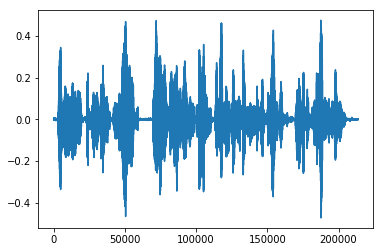

In [56]:
## Plot of a sound file
plt.plot(sf.read(f1)[0])

In [28]:
import soundfile as sf
filepath = '/Users/sanmathikamath/projects/datasets/arctic/combined_Librispeech_full_89_4014_8770.flac'
files = ['new_combined_file.flac']
inst, sr = sf.read(filepath)
block_size = sr*3
# blocks_ = np.zeros(block_size)
instances = []
for f in files:
    blocks = sf.blocks(f, blocksize=block_size, overlap = block_size - sr)
    for j in blocks :
        instances.append(j)
    instances = instances[:-1]

instances=np.array(instances)
prob_two = clf2.predict_proba(extract_embedding(np.array(instances), encoder))
prob_two.shape

(28, 3)

In [29]:
y_two = np.argmax(prob_two, axis=1)

In [124]:
cumulative_prob_two = np.zeros(prob_two.shape)
cumulative_prob_two[0]= prob_two[0]
for i in range(1,len(prob_two)):
    cumulative_prob_two[i] = (prob_two[i]+cumulative_prob_two[i-1])/np.sum(prob_two[i]+cumulative_prob_two[i-1])
    #print(cumulative_prob_two[i])
#prob_two[:5], cumulative_prob_two[:5]
#(prob_two[1]+prob_two[0])/np.sum(prob_two[1]+prob_two[0])

(array([[0.28823934, 0.59010184, 0.12165883],
        [0.29529533, 0.58188043, 0.12282424],
        [0.30160162, 0.57841541, 0.11998296],
        [0.30938837, 0.5746082 , 0.11600344],
        [0.31251849, 0.57677597, 0.11070553]]),
 array([[0.28823934, 0.59010184, 0.12165883],
        [0.29176733, 0.58599113, 0.12224153],
        [0.29668448, 0.58220327, 0.12111225],
        [0.30303642, 0.57840573, 0.11855784],
        [0.30777746, 0.57759085, 0.11463169]]))

In [30]:
prob_two = clf2.predict_proba(X_two_val)

In [38]:
import matplotlib.cbook as cbook
img_file_path ='/Users/sanmathikamath/projects/Speaker_Recognition/voicemap-master/notebooks/neutral_C.png'
with cbook.get_sample_data(img_file_path) as image_file:
    imageC = plt.imread(image_file)


In [39]:
images=[imageA,imageB,imageC]

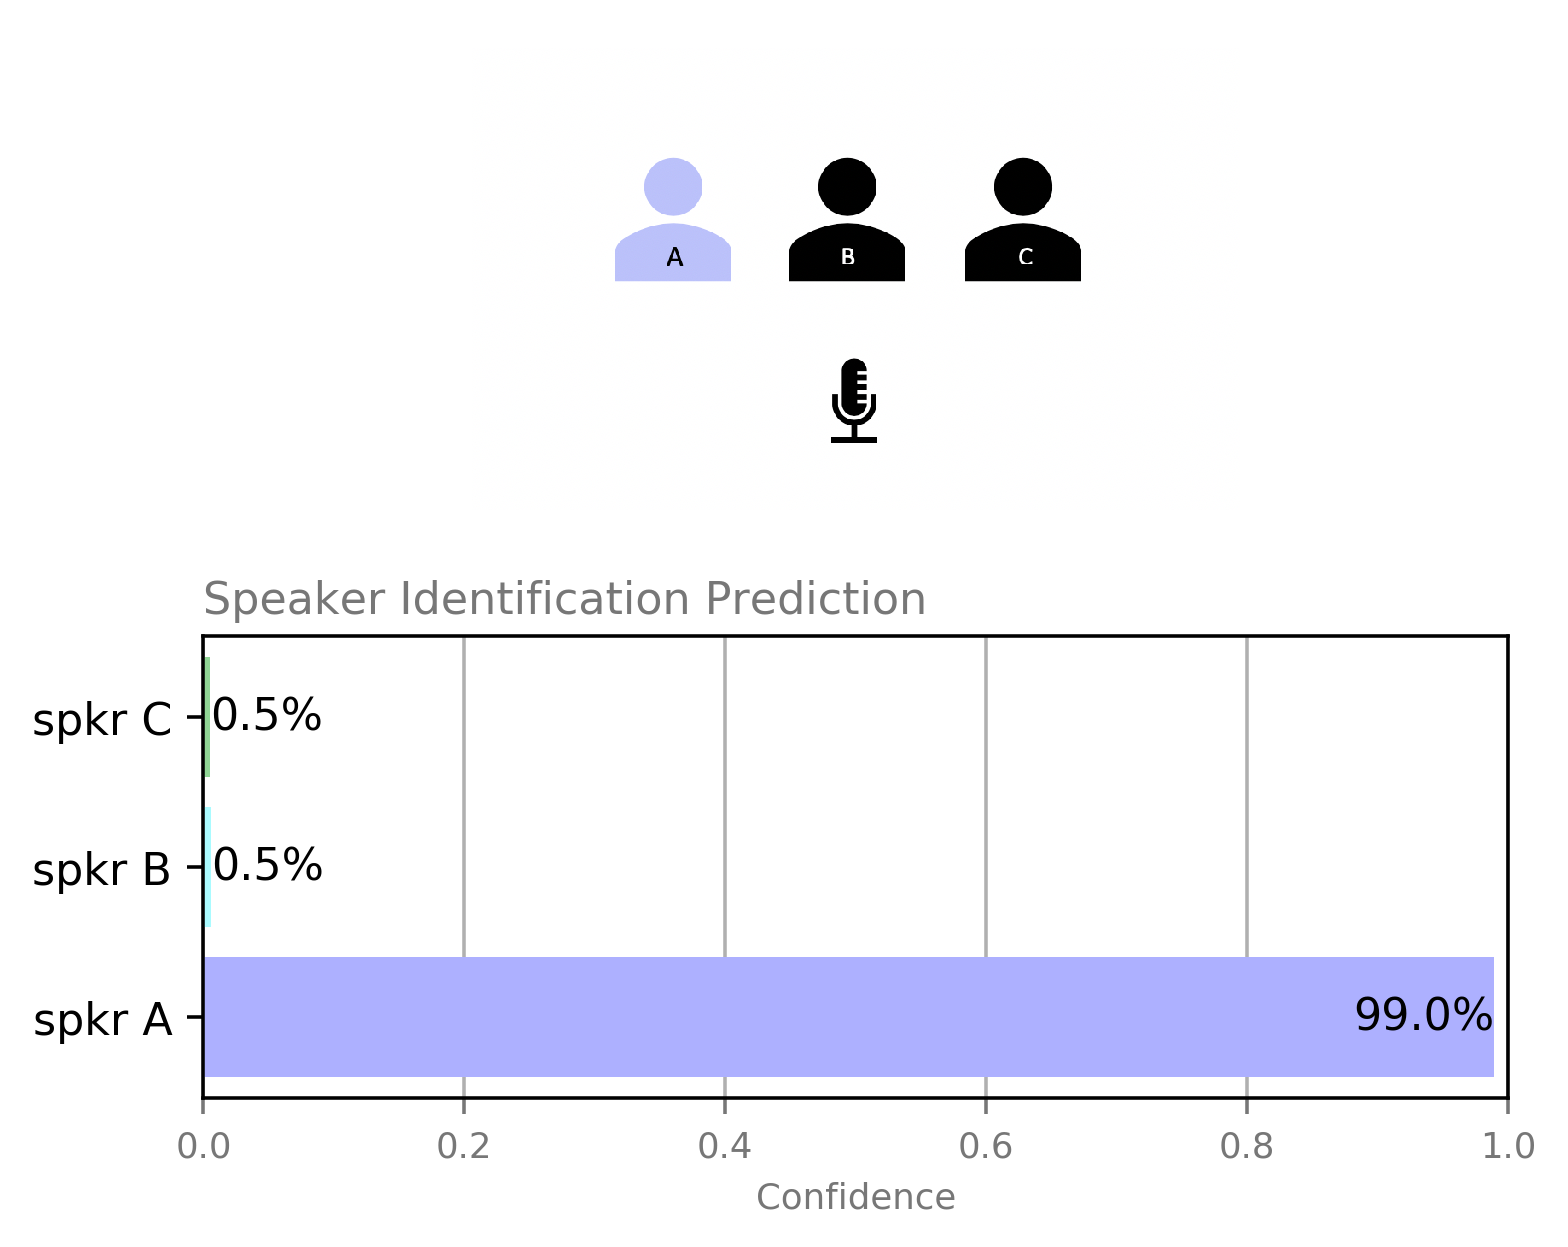

In [53]:
fig, ax = plt.subplots(nrows=2,figsize=(5,4), dpi = 320)
def draw_barchart(sp_i, fig=fig, ax=ax):
    ax[0].imshow(images[y_two[sp_i]])
    ax[0].set_axis_off()
    
    ax = ax[1]
    ax.clear()
    spkr_names_three = ['spkr A', 'spkr B', 'spkr C']
    #spkr_names_three = [str(x) for x in np.unique(y_two_val)]
    colors = dict(zip(
        spkr_names_three,
        ['#adb0ff', '#aafbff', '#90d595']
    ))
    
    ax.barh(spkr_names_three, prob_two[sp_i], color=[colors[x] for x in spkr_names_three])
    ax.set_xlim(0,1)
    # iterate over the values to plot labels and values (Tokyo, Asia, 38194.2)
    for i, (value, name) in enumerate(zip(prob_two[sp_i], spkr_names_three)):
        #ax.text(value, i,     name, size=14, weight=600, ha='right', va='bottom')  # Tokyo: name
        if value < 0.5:
            ax.text(value, i,     str(round(value*100,1))+'%',size=10, ha='left',  va='center')   # 38194.2: value
        else:
            ax.text(value, i,     str(round(value*100,1))+'%',size=10, ha='right',  va='center')   # 38194.2: value
    ax.text(0, 1.05, 'Speaker Identification Prediction',
                transform=ax.transAxes, size=10, weight=100, ha='left',  color='#777777')
    
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    #ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Confidence',color='#777777', size=8)
    #ax.set_ylabel('Speaker')
    ax.tick_params(axis='x', colors='#777777', labelsize=8)
    #ax.text(1, -0.15, 'by @sanmathikamath', transform=ax.transAxes, ha='right', size =6,
    #        color='#777777', bbox=dict(facecolor='white', alpha=0.2, edgecolor='white'))
    
    #ax.set_yticks([])
    #ax.margins(0, 0.01)
    
    #plt.subplots_adjust(left = 0.2, right=0.70,  top=1.1, bottom=0.1 )
    
    plt.box(True)
    plt.tight_layout()
draw_barchart(0, fig, ax)
plt.savefig('overview.png', dpi=250)

IndexError: index 28 is out of bounds for axis 0 with size 28

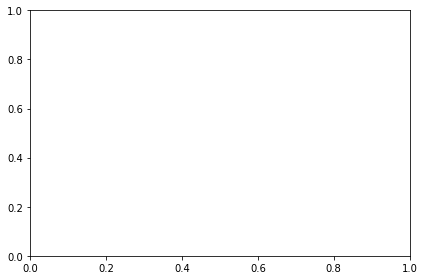

In [52]:
import matplotlib.animation as animation
from IPython.display import HTML
#fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(0,len(prob_two)))
HTML(animator.to_jshtml())
#HTML(animator.save('gif1.mp4'))

In [16]:
## Acc plots over num_speakers
import matplotlib.pyplot as plt
n = [2,4,6,10,20]
acc= [99.07 ,98.56, 87.65, 79.601, 65.539]
plt.bar(n, acc)
plt.xlabel('Number of speakers')
plt.ylabel('Classification Accuracy')
plt.show()

Text(0,0.5,'Classification Accuracy')

### Plot of prediction using sliding window 
Splitting one file into its various windows

In [109]:
testing_files_ind = np.random.choice(X_test_files.index.values, 3)
testing_files = X_test_files[testing_files_ind]
testing_files
output_test = y_test[testing_files_ind]
testing_files

11255    /Users/sanmathikamath/projects/voicemap-master...
27001    /Users/sanmathikamath/projects/voicemap-master...
26674    /Users/sanmathikamath/projects/voicemap-master...
Name: filepath, dtype: object

In [110]:
import soundfile as sf
sr = 16000
block_size = n_seconds*sr
output_labels_pred =[]
for file in testing_files:
    print(file)
    blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
    instances=[]
    for j in blocks :
        instances.append(j)
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/2514/149482/2514-149482-0021.flac
/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/8324/286682/8324-286682-0032.flac
/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/train-clean-100/8238/283452/8238-283452-0037.flac


In [111]:
output_labels_pred, output_test

([array([3240, 2136, 7264, 7264, 2911, 6181, 2514, 2911, 2911]),
  array([5339,  831, 7226, 6454, 8095, 8095, 6454, 4267,  831]),
  array([ 211,  103,  125, 1116, 1235,  460, 1867, 1116, 8419])],
 11255    2514
 27001    8324
 26674    8238
 Name: speaker_id, dtype: int64)

### Plot of prediction using sliding window over multiple files
Splitting one file into its various windows and combining multiple files of same speaker

In [113]:
test_speakers = np.random.choice(np.unique(y_test), 3)

In [114]:
output_labels_pred =[]
for spkr_j in test_speakers:
    print(spkr_j)
    spkr_j_ind = y_test[y_test == spkr_j].index.values
    spkr_files = X_test_files[spkr_j_ind]
    instances=[]
    for file in spkr_files:
        blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
        for j in blocks :
            instances.append(j)
        instances = instances[:-1]
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

6454
8324
1970


In [110]:
output_labels_pred, test_speakers

([array([ 289, 1867, 1867, 1867, 1867, 1867, 7635, 7635, 1867, 7635, 1867,
         1867, 1867, 1867, 7635, 7635, 1867, 1867, 1867, 1867, 1867,  289,
          289,  289,  289, 1867, 7059, 7059, 7059,   39, 4406, 4406, 4406,
         7635, 7635, 7635, 4406, 1867, 1867, 1867, 1867, 1867, 1867, 1867,
         1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 1867, 7059,
          289, 1867, 1867, 4406, 4406, 4406, 3982, 7635, 3982, 3982, 1867,
         7635, 7635, 1867, 4406, 4406, 1867, 1867, 1867, 1867, 3982, 1867,
         7635, 4406, 1867, 1867, 4406, 4406, 4406, 1867, 1867, 4406, 4406,
         1867,  289, 1867, 1867, 7635, 7635, 3982, 3982, 7635, 7635, 1867,
         1867, 7635,  289, 1867, 1867, 4406, 4406, 4406, 1867, 1867, 7635,
         4406, 1867, 1867, 4406, 4406, 1867, 4406, 4406, 3982, 1867, 1867,
         1867, 7635, 1867, 1867,  289, 1867, 1867, 7635, 3112, 2989, 1867,
         7635,   39, 1867, 1867, 1867,   39, 1867, 1867, 1867, 7635, 1867,
         1867, 3982, 1867

In [118]:
from collections import Counter
print("Predicted_label:", Counter(output_labels_pred[0]).most_common(1)[0][0], "\nActual label:",test_speakers[0])

Predicted_label: 6454 
Actual label: 6454


In [149]:
##Unknown speaker predictions for sliding window
unknown = valid.df['filepath'][0]
import soundfile as sf
sr = 16000
n_seconds=3
block_size = n_seconds*sr
output_labels_pred =[]
for file in [unknown]:
    print(file)
    blocks = sf.blocks(file, blocksize=block_size, overlap = block_size//2)
    instances=[]
    for j in blocks :
        instances.append(j)
    instances = np.array(instances[:-1])
    query_instance_ = preprocessor.instance_preprocessor(instances[:,:,np.newaxis])
    emb_testing = encoder.predict(query_instance_)
    output_labels_pred.append(clf.predict(emb_testing))

/Users/sanmathikamath/projects/voicemap-master/data/LibriSpeech/dev-clean/84/121123/84-121123-0026.flac


In [146]:
output_labels_pred

[array([5778, 1502, 8123, 5778, 1502, 1502, 1502, 5778])]

In [150]:
accuracy_score(y_val, y_pred)

0.8666098444491797

### EER

In [24]:
# y_pred = clf.predict(val_emb)
# y_val = y_test
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
#y_pred == y_val
#y_val, y_pred
y_b = label_binarize(y_tr, classes=np.unique(y_tr))
print(y_b.shape)

(19056, 250)


In [25]:
clf3 = OneVsRestClassifier(svm.SVC(gamma = 'scale', probability=True))
print(clf3)
clf3.fit(X_tr, y_b) 

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)


KeyboardInterrupt: 

In [ ]:
y_pred  = clf3.predict(val_emb)

In [ ]:
probs3 = clf3.predict_proba(val_emb) 

In [ ]:
#np.sum(probs3, axis = 0).shape
#clf3.multilabel_
y_vb = label_binarize(y_val, classes=np.unique(y_tr))
print(y_vb.shape, y_b.shape)

In [ ]:
#EER
from sklearn.metrics import roc_curve
# Compute ROC curve 
n_classes = 250
EER = dict()
#roc_auc = dict()
sum_eer = 0
for i in range(n_classes):
    fpr, tpr, threshold = roc_curve(y_vb[:, i], y_pred[:, i])
    #roc_auc[i] = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    EER[i] = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    sum_eer+=EER[i]
print("mean EER(%):", sum_eer/250*100)

In [101]:
print("Mean EER over all classes", sum(EER.values())/250)

Mean EER over all classes 5.17795154332852e-05


In [100]:
y_pred_class = np.unique(y_val)[np.argmax(probs3, axis =1)]
accuracy_score(y_val, y_pred_class)

0.870658427445131

In [163]:
probs = clf.predict_proba(val_emb)
probs


AttributeError: predict_proba is not available when  probability=False

### KMeans Clustering

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
from time import time
X_train = emb
from sklearn.decomposition import PCA
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
def bench_k_means(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=len(data))))

    return estimator

In [42]:
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
km = bench_k_means(KMeans(init='random', n_clusters=250, n_init=10),
              name="random initialization", data=X_train, labels = y_train)


init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
random initialization	15.81s	400260	0.815	0.822	0.818	0.512	0.760	0.213


In [154]:
y_clus = km.predict(X_train)
np.unique(y_clus)

0.00020990764063811922

## Code Profiling